In [77]:
import numpy as np
import torch
import os

from tqdm.notebook import tqdm, trange
import open3d as o3d

from utils.data import load_xyz_file
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss

from utils.viz import viz_many, viz_many_mpl
import matplotlib.pyplot as plt

from omegaconf import OmegaConf


# Load model

Load a model from checkpoint and evaluate with it 

In [78]:
sorted(os.listdir("trained-models/"))

['.ipynb_checkpoints',
 '2022-03-15-15-48-pool_max',
 '2022-03-15-22-45-pool_mean',
 '2022-03-16-09-00-pool_add',
 '2022-03-16-15-40-conv_gat',
 '2022-03-17-11-23-conv_edge',
 '2022-03-30-18-29-pugnn-gat-1',
 '2022-03-30-19-08-pugnn-gat-2-heads',
 '2022-03-30-20-11-pugnn-radius-0.25',
 '2022-04-05-16-58-pupt-baseline',
 '2022-04-05-19-29-pupt-baseline-refined',
 '2022-04-06-10-37-pugcn-baseline-refiner-transformer',
 '2022-04-06-11-50-pugcn-baseline',
 '2022-04-06-12-23-pugcn-baseline-36',
 '2022-04-06-13-10-pugcn-baseline-2idgcn',
 '2022-04-06-13-48-pugcn-baseline-3dilations',
 '2022-04-06-14-35-pupt-baseline-36',
 '2022-04-06-15-36-pupt-baseline-2ipt',
 '2022-04-06-16-12-pupt-baseline-3dilations',
 '2022-04-06-16-55-pupt-baseline']

In [79]:
#d = os.listdir(os.path.join("trained-models"))[0]
ckpt_dir = sorted(os.listdir("trained-models"))[-1]


In [80]:
ckpt_dir

'2022-04-06-16-55-pupt-baseline'

In [81]:
os.listdir(os.path.join("trained-models", ckpt_dir))

['ckpt_epoch_10', 'ckpt_epoch_1', 'ckpt_epoch_5', 'config.yaml']

In [82]:
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
print(exp_conf)

{'name': 'pupt-baseline', 'model_config': {'r': 4, 'k': 20, 'dilations': [1, 2], 'n_ipt_blocks': 1, 'channels': 24, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'pool_type': 'max', 'dynamic': False, 'use_refiner': False}, 'train_config': {'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}}


In [83]:
ckpt_name = "ckpt_epoch_10"

In [84]:
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))

In [85]:
history = OmegaConf.create(checkpoint["history"])

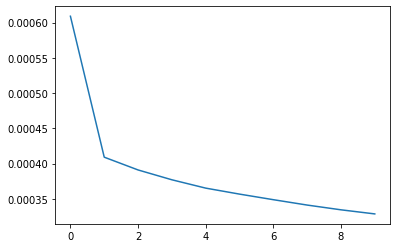

In [86]:
plt.plot(history.train_loss)

In [87]:
model_config = exp_conf.model_config

In [88]:
model_config

{'r': 4, 'k': 20, 'dilations': [1, 2], 'n_ipt_blocks': 1, 'channels': 24, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'pool_type': 'max', 'dynamic': False, 'use_refiner': False}

In [89]:
from pugcn_lib.models import PUGCN, PUGNN, PUGNNRadius, PUGCNRefinedTransformer, PUInceptionTransformer

In [90]:
#model = PUGCN(**model_config)
model = PUInceptionTransformer(**model_config)
#model = PUGNN(**model_config)
#model = PUGNNRadius(**model_config)
#model = PUGCNRefinedTransformer(**model_config)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# Qualitative

In [91]:
input_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "input_256")
gt_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "gt_1024")


In [92]:
file = "horse.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)

In [93]:
out = model(data).detach()

In [94]:
#o3d
viz_many([data.numpy(), gt.numpy(), out.numpy()]) 

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

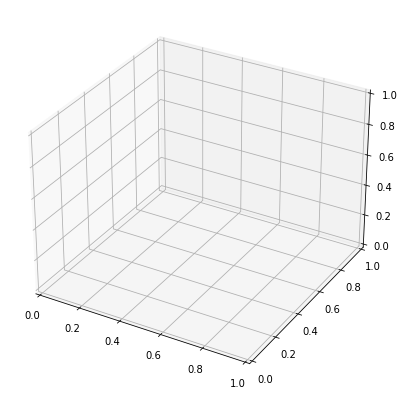

In [76]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection='3d')
viz_many_mpl([data.numpy(), gt.numpy(), out.numpy()], ax=ax) 

# Quantitative

In [69]:
from utils.losses import hausdorff_loss
from time import time

In [70]:
chamfer_loss = ChamferLoss()

chamfer_losses = []
hausdorff_losses = []
for file in tqdm(os.listdir(input_dir)):
    # Load files
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    #predict
    t = time()
    out = model(data)
    t = time() - t
    
    #chamfer
    d1, d2, _, _ = chamfer_loss(out.unsqueeze(0).cuda(), gt.unsqueeze(0).cuda())
    loss = d1.mean() + d2.mean()
    chamfer_losses.append(loss.item())
    
    #hausdorff
    
    loss = hausdorff_loss(out.detach(), gt.detach())
    hausdorff_losses.append(loss)
    

  0%|          | 0/127 [00:00<?, ?it/s]

In [71]:
print(np.mean(chamfer_losses) * 10**3)
print(np.mean(hausdorff_losses) * 10**3)
print(t)

2.114317601035151
84.59926401959716
0.01249241828918457


In [72]:
t = OmegaConf.create(
    {
        "epochs_trained": checkpoint["epoch"],
        "chamfer_loss": float(np.mean(chamfer_losses) * 10**3),
        "hausdorff_loss": float(np.mean(hausdorff_losses) * 10**3),
        "model_size": checkpoint["model_size"],
        "inference_time": t
    }
)

In [73]:
exp_conf

{'name': 'pupt-baseline', 'model_config': {'r': 4, 'k': 20, 'dilations': [1, 2], 'n_ipt_blocks': 1, 'channels': 24, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'pool_type': 'max', 'dynamic': False, 'use_refiner': False}, 'train_config': {'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}}

In [74]:
results = exp_conf
results.results = t

In [75]:
OmegaConf.save(config=results, f = os.path.join("results", f"results-{ckpt_dir}-{ckpt_name}.yaml"))